# LLM-based TTS

# Agenda
1. [TortoiseTTS](#TortoiseTTS)
1. [Overview](#overview-of-tts-systems)
1. [Creating LLM TTS](#own-small-tts)
1. [Homework](#Homework) 

# Intro

# TortoiseTTS

DALL-E inspired TTS
 
paper: [Better speech synthesis through scaling](https://arxiv.org/pdf/2305.07243)

## Ideas


1. LLM for core generation (GPT2)
1. Diffusion for details rendering 
1. Large pretraining


Questions to answer:
1. How to represent audio to make use of LLM?
1. How to condition generations on text?
1. How to condition on speaker? 
1. How to reconstruct audio from generated tokens?


## General inference scheme


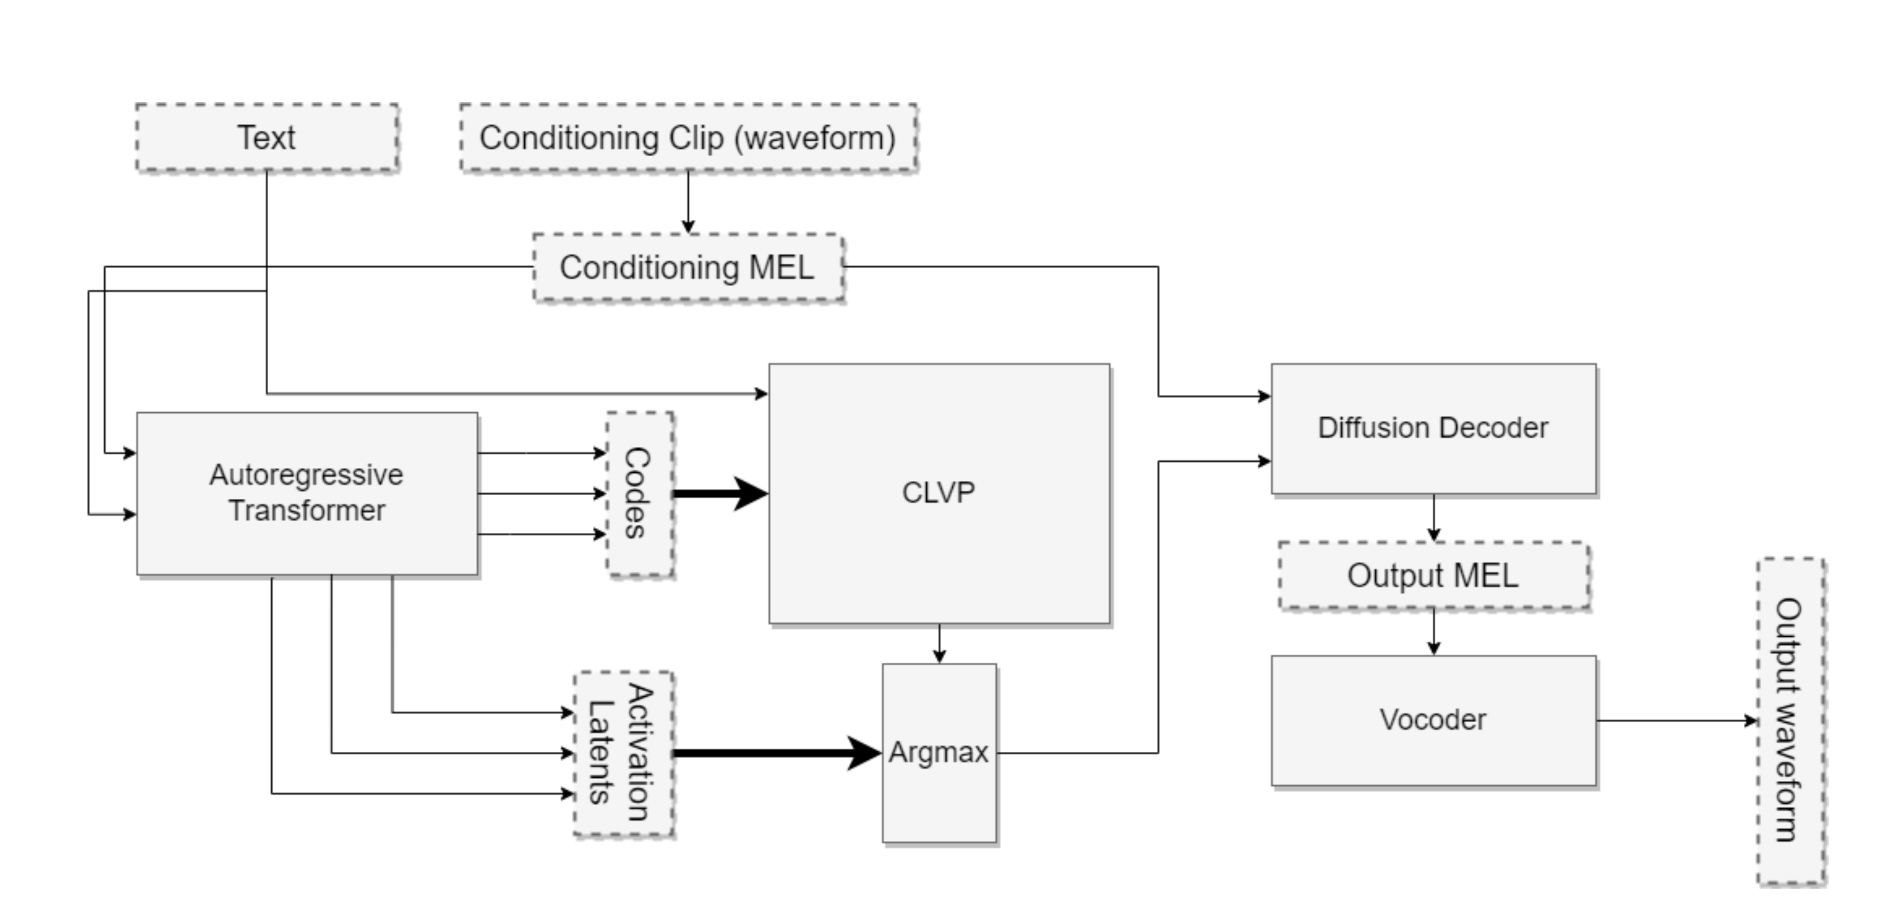


## 1. VQ-VAE


paper: [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937)

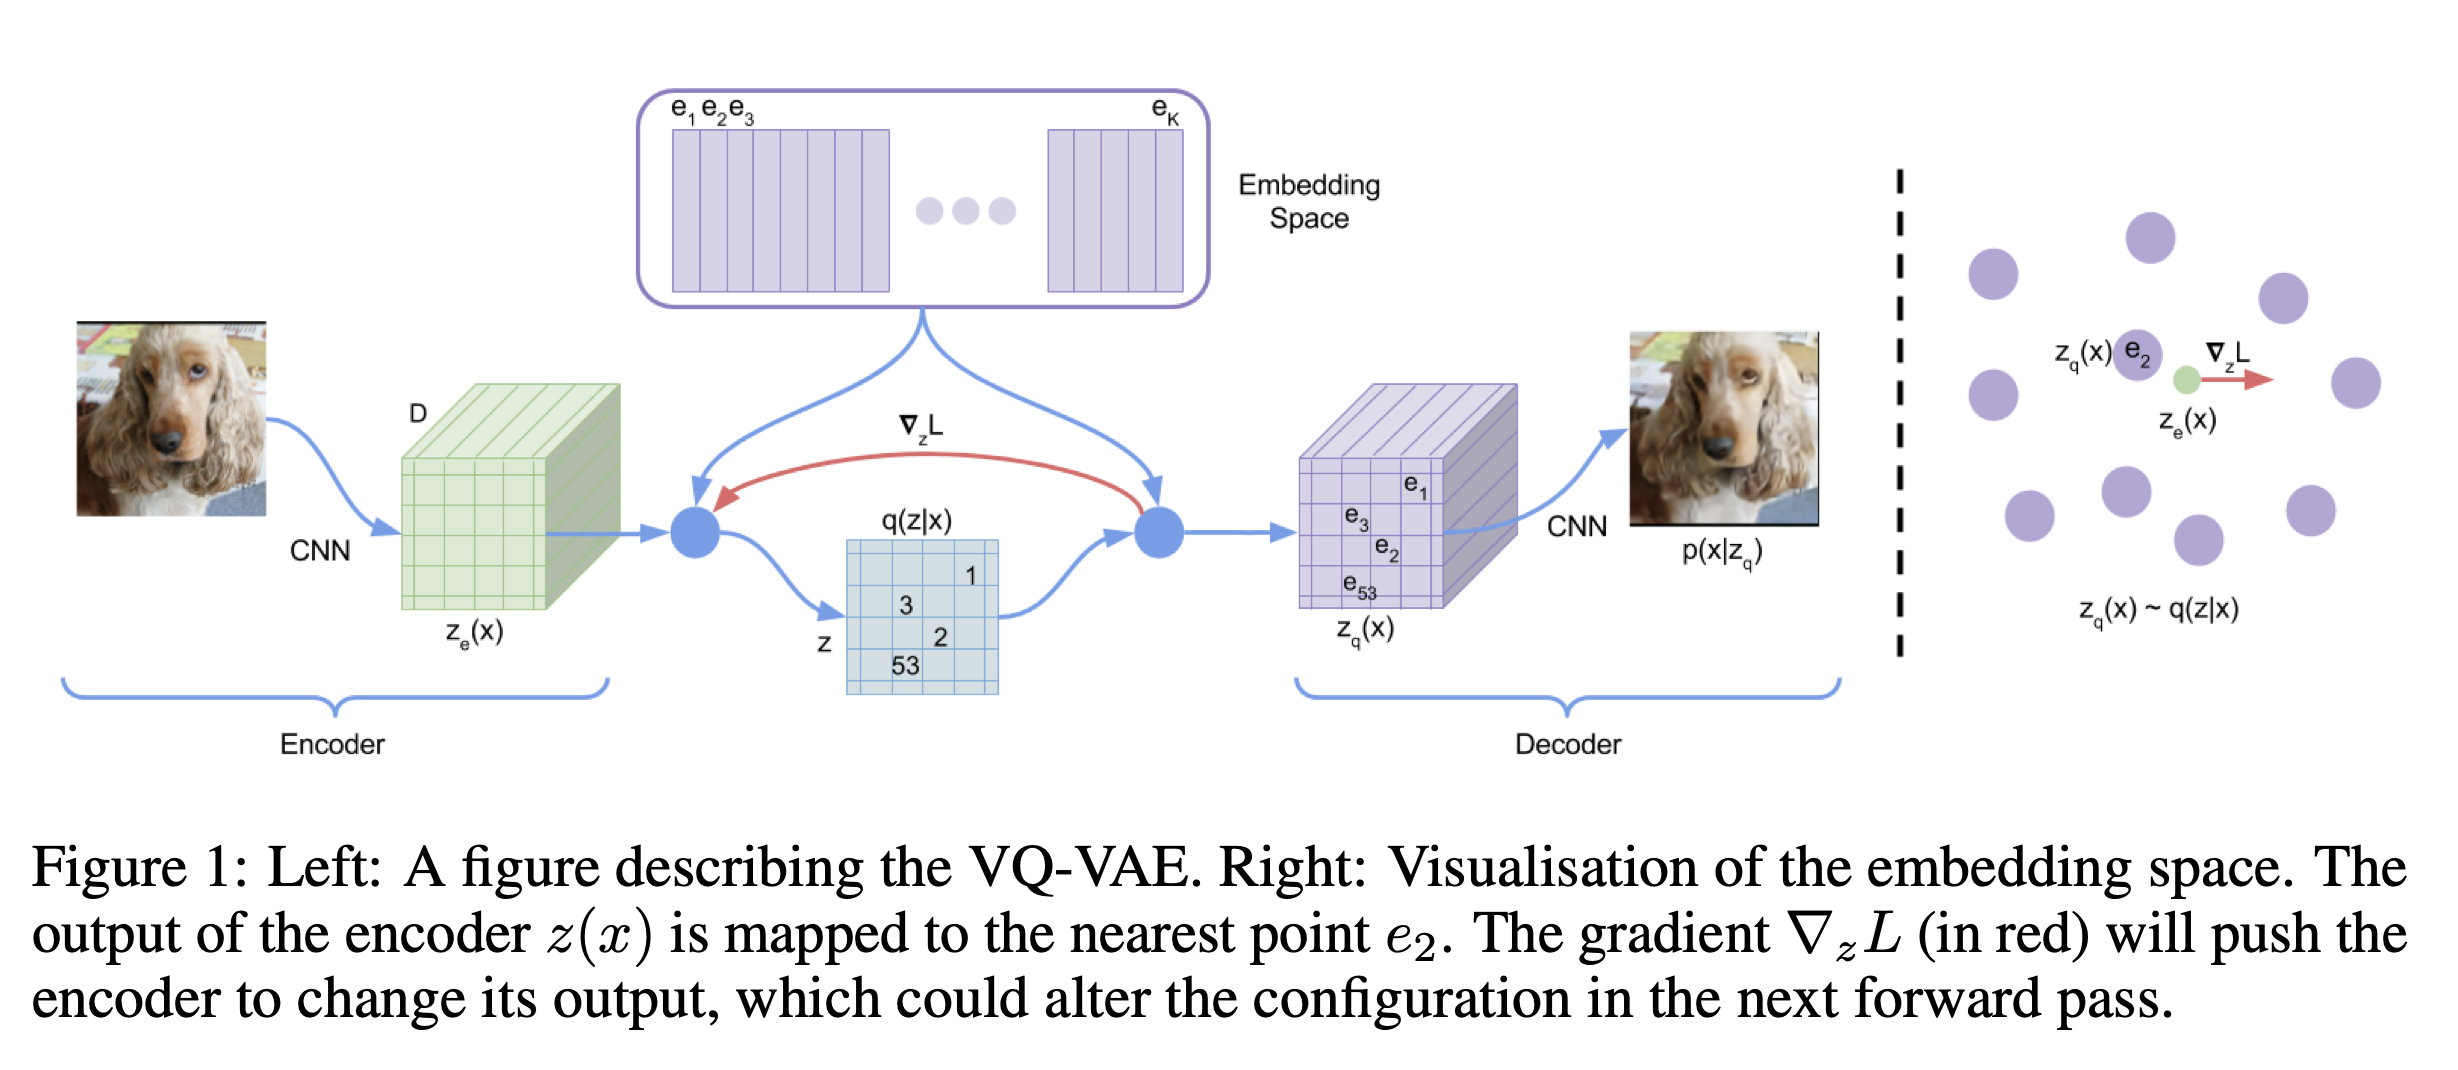

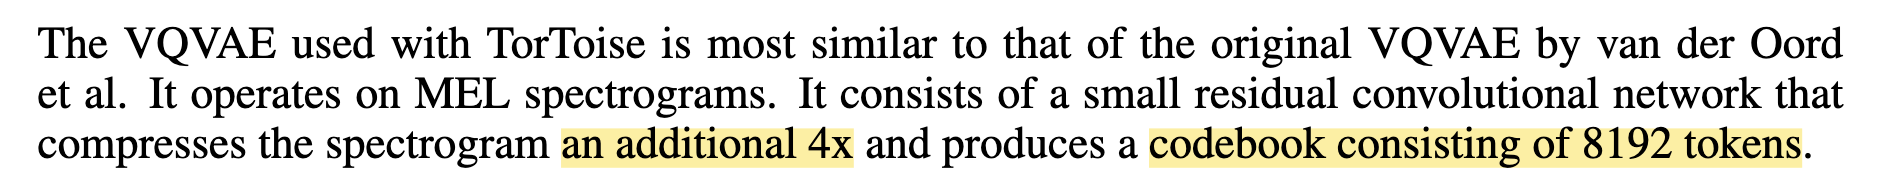


## Autoregressive Transformer


BPE 

check whisper lection

* causal attention
* transformer blocks
* shift loss

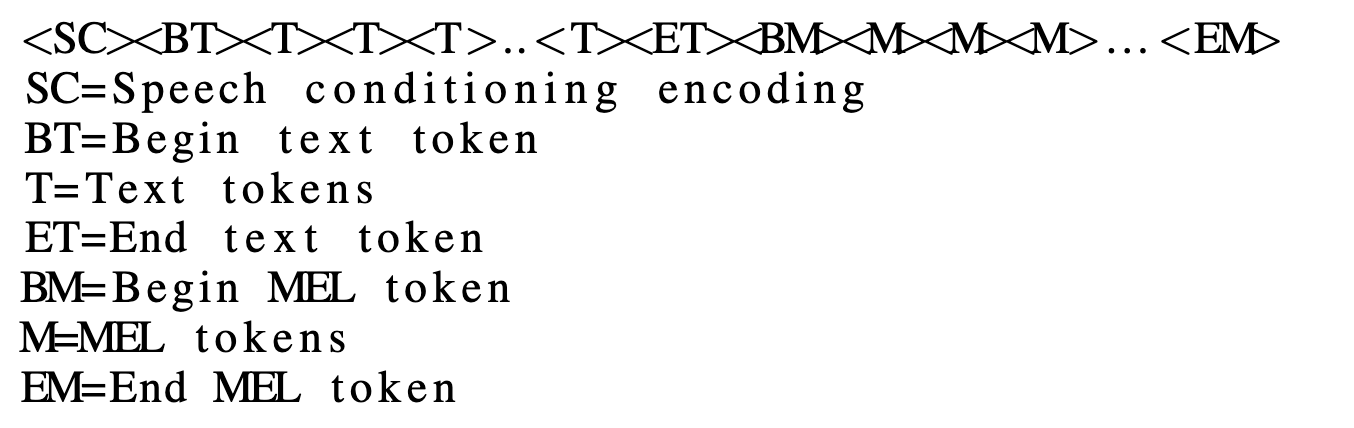

## Speaker conditioning

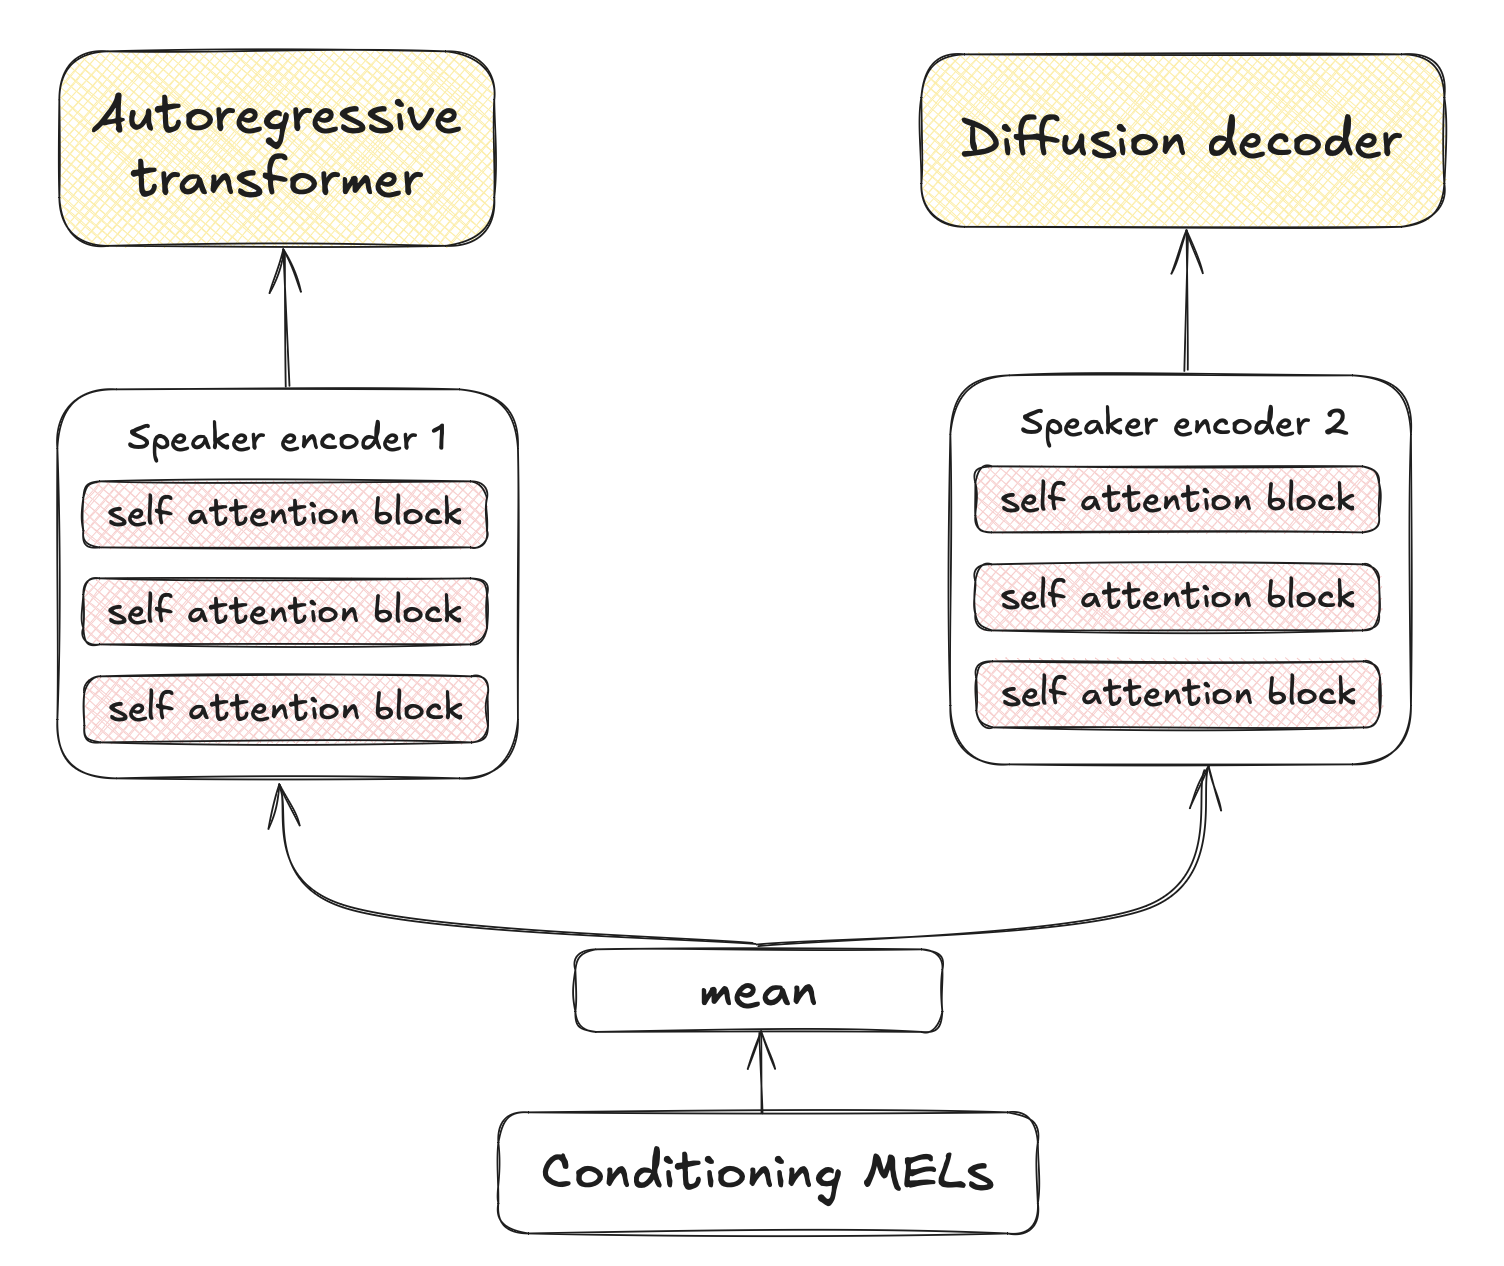

## Diffusion decoder

* DDIM
* latent input fine-tuning
* 

## CLVP

Contrastive Language-Voice Pretrained Transformer, inspired by CLIP

paper: [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/pdf/2103.00020)

* pretraining on matching pairs
* symmetric cross-entropy loss

Given a batch of N (image, text) pairs, CLIP is trained to predict which of the N × N possible (image, text) pairings across a batch actually occurred. To do this, CLIP learns a multi-modal embedding space by jointly training an image encoder and text encoder to maximize the cosine similar- ity of the image and text embeddings of the N real pairs in the batch while minimizing the cosine similarity of the embeddings of the N2 − N incorrect pairings.

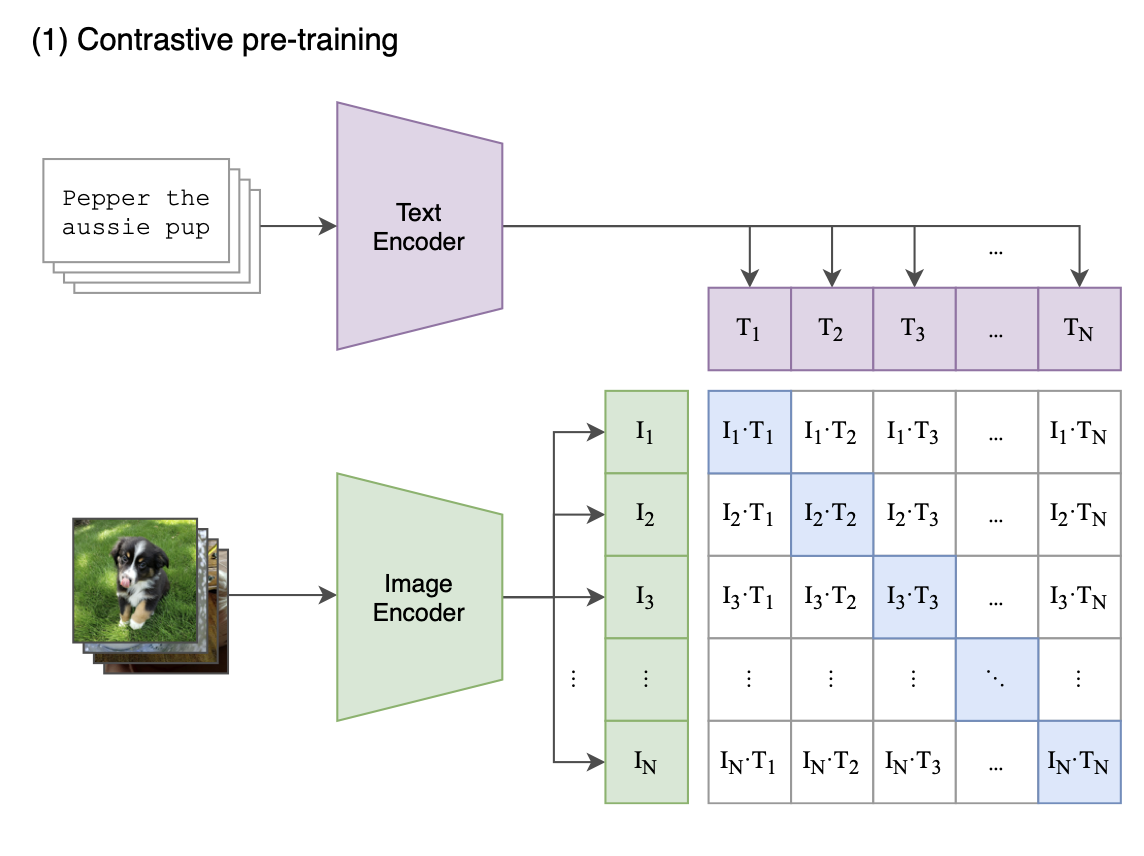

# Overview of TTS systems

## VALL-E (2023)

paper: [Neural Codec Language Models are Zero-Shot Text to Speech Synthesizers](https://arxiv.org/pdf/2301.02111)

* codec with RVQ
* AR transformer for the first RVQ layer
* non-AR transformer for all other layers
* speaker conditioning without separate encoder

### Encodec

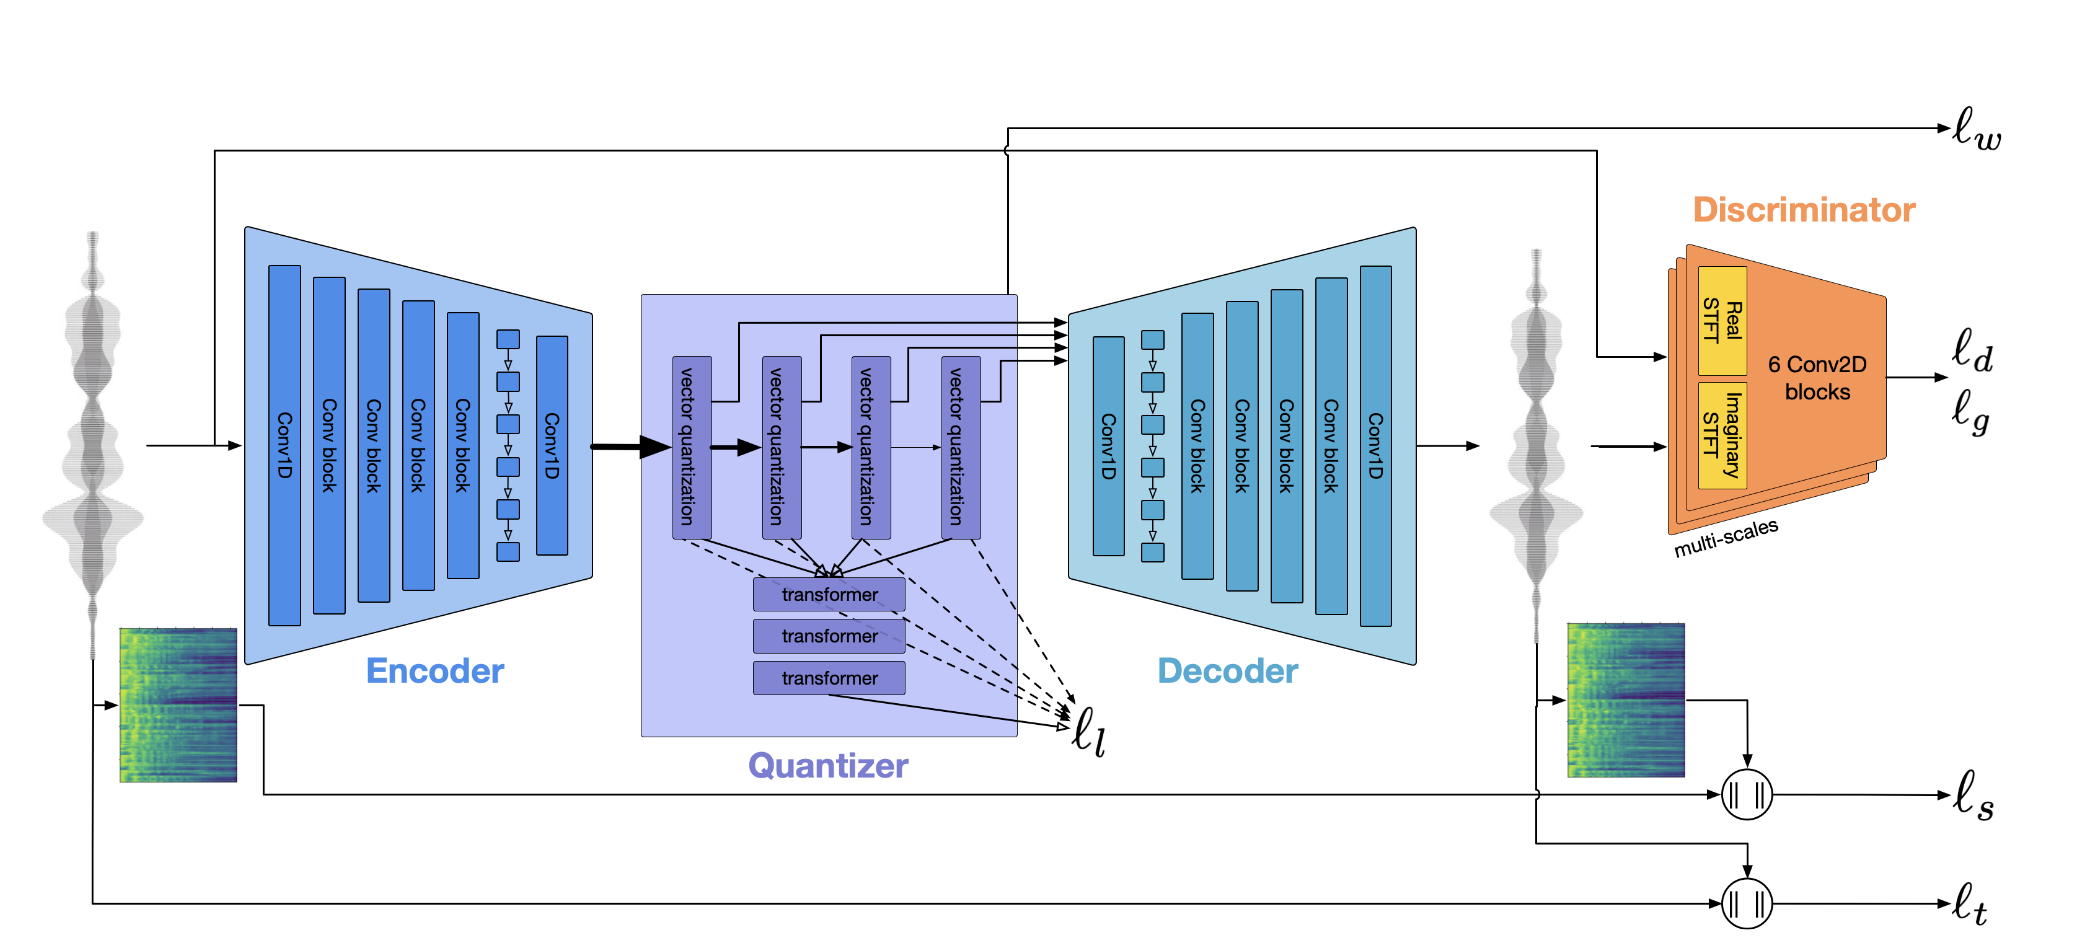

### VALL-E

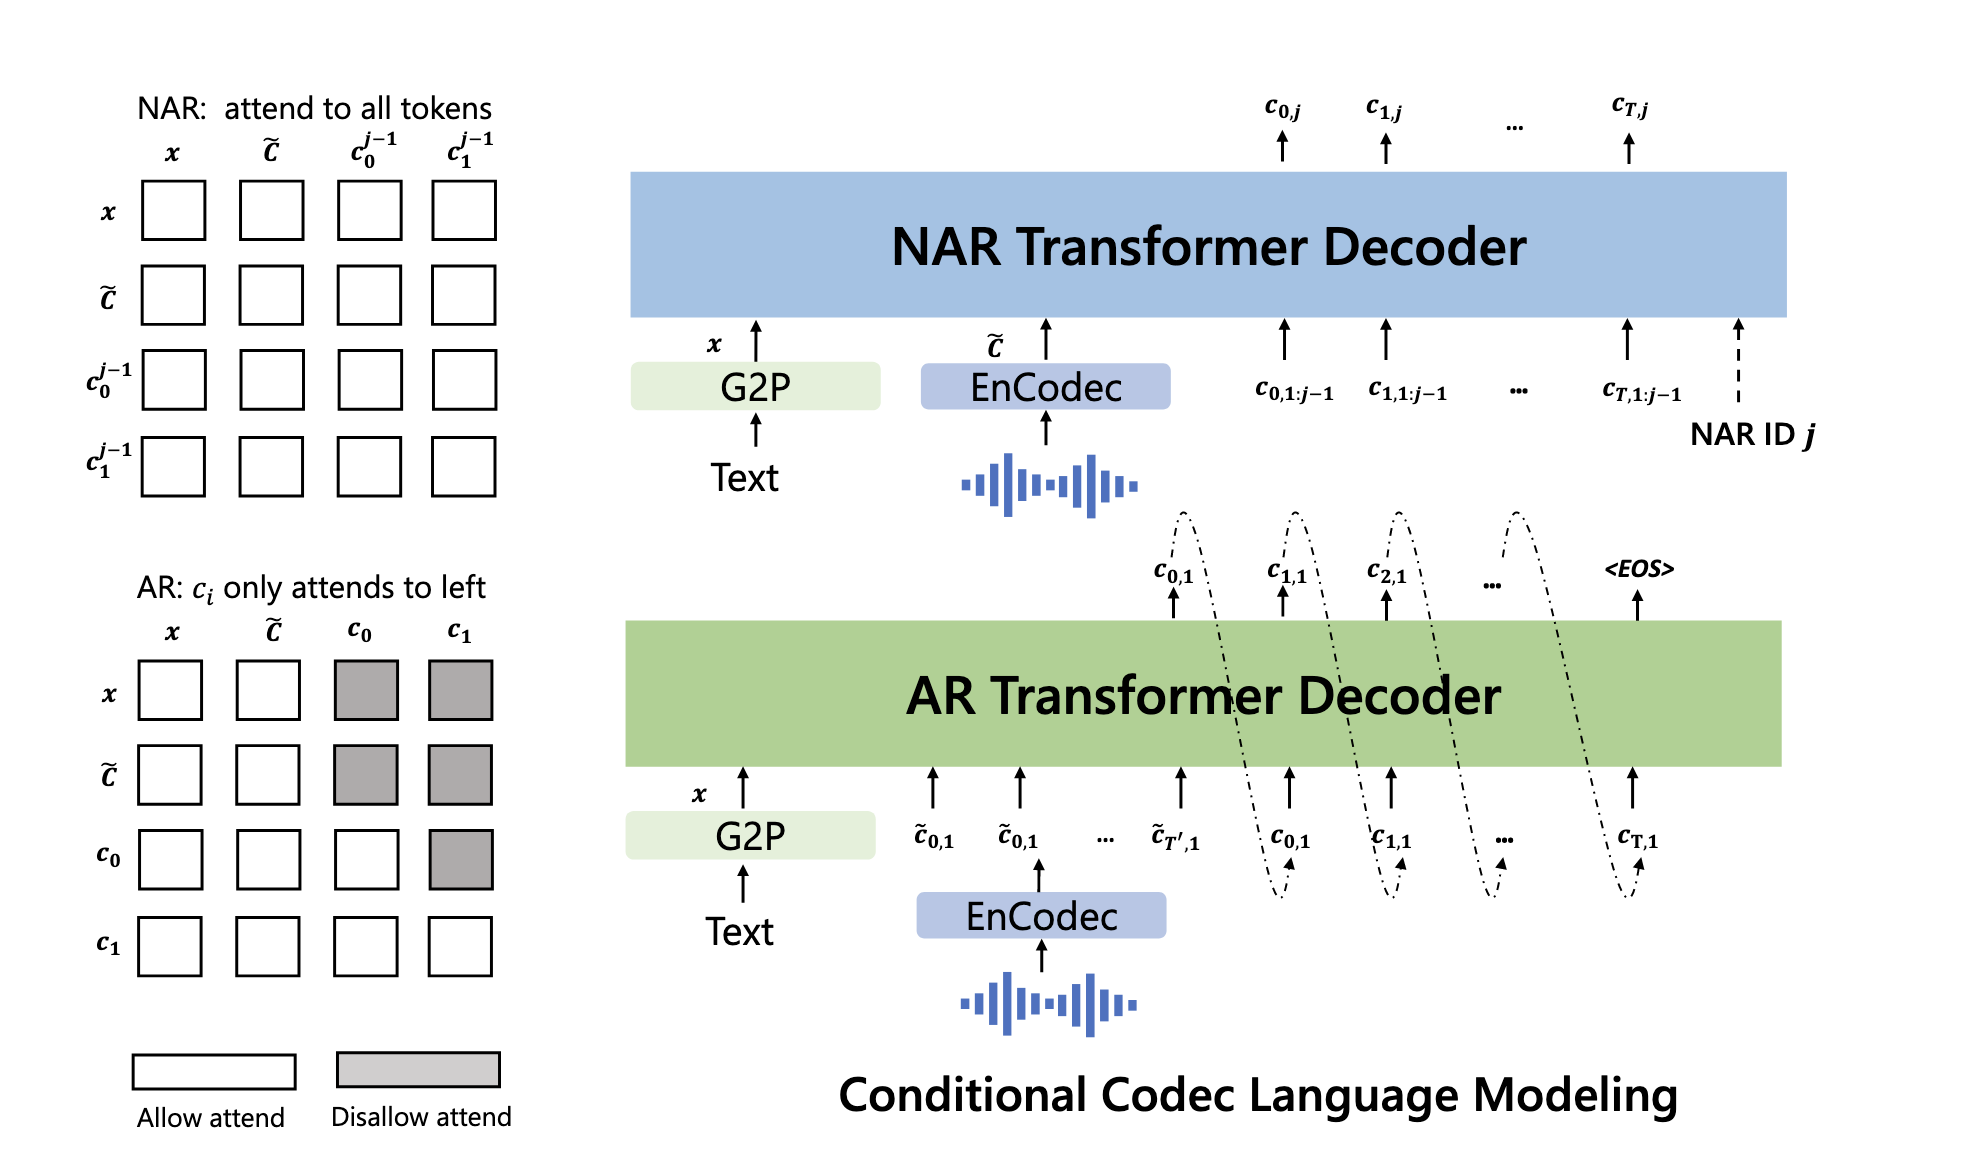

## xTTS v2 (2024)

paper: [XTTS: a Massively Multilingual Zero-Shot Text-to-Speech Model](https://arxiv.org/pdf/2406.04904) 

* pretrained speaker encoder
* cnn decoder

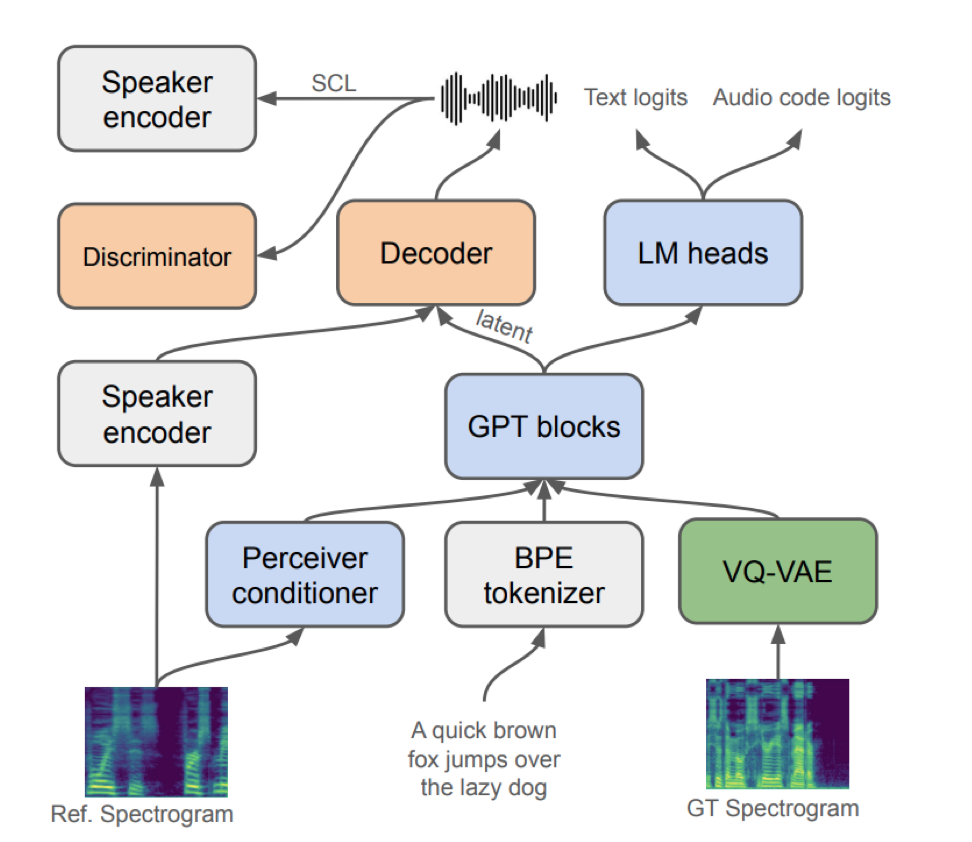

## CosyVoice 2 (2024)

paper: [CosyVoice 2: Scalable Streaming Speech Synthesis with Large Language Models](https://arxiv.org/pdf/2412.10117)

* Finite scalar quantization (FSQ) for VQ-VAE
* 


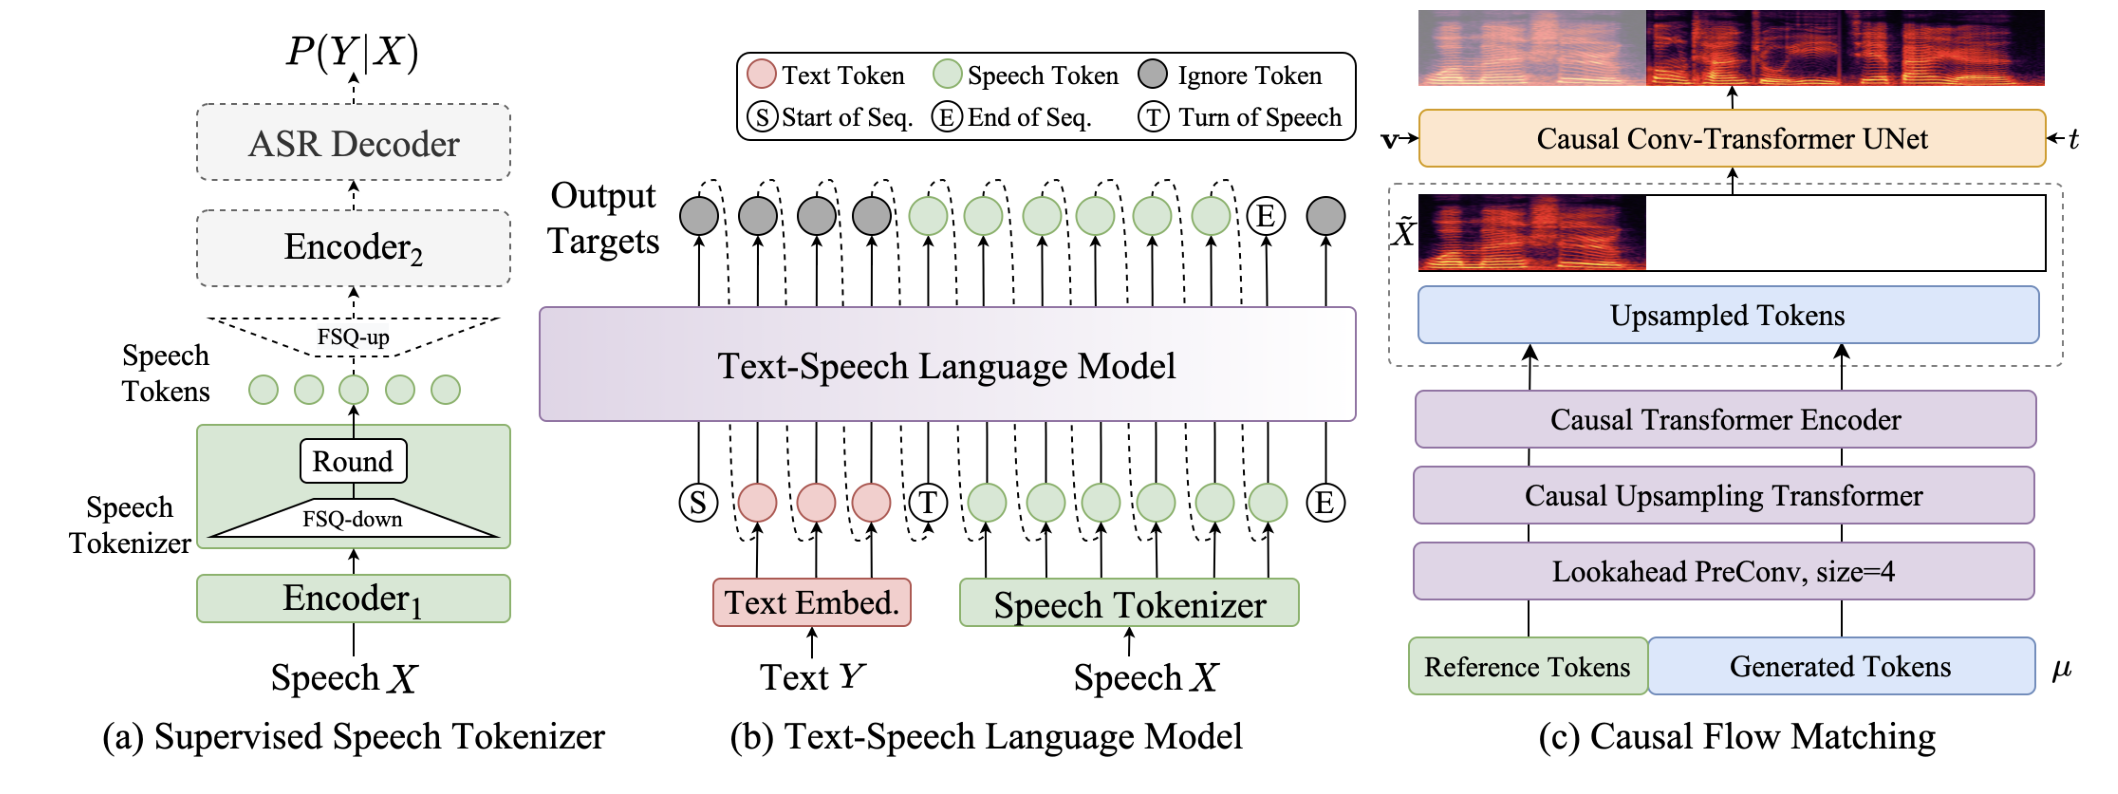

## Parler TTS (2024)

paper: [Natural language guidance of high-fidelity text-to-speech with synthetic annotations](https://arxiv.org/pdf/2402.01912)

* AR for all RVQ layers with delayed pattern
* Speaker conditioning via cross-attention

In [ ]:
display.Audio(audio_values[0].detach().cpu().numpy(), rate=processor.sampling_rate)

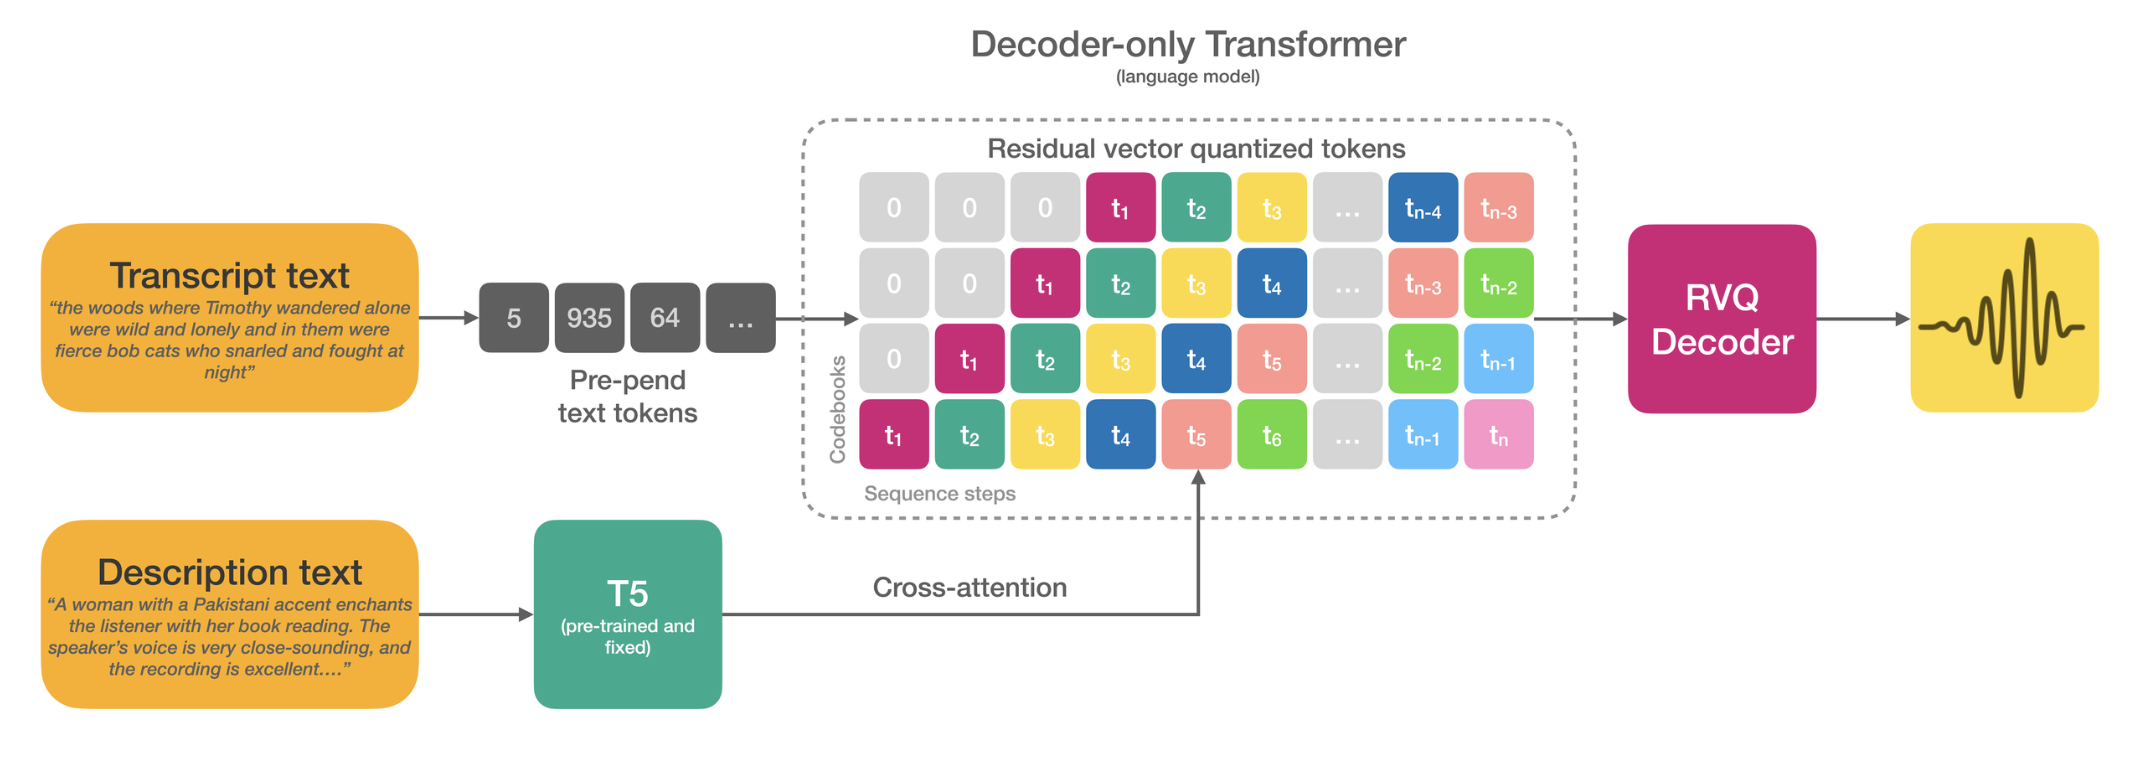

# Training LLM TTS 

* Flattened encodec with 2 quantizers 
* bpe tokenizer 
* gpt2
* native decoder

## 1. Dataset

LJspeech: https://www.kaggle.com/datasets/mathurinache/the-lj-speech-dataset

In [1]:
import torchaudio
import os

root_dir = "./LJSpeech" 
os.makedirs(root_dir, exist_ok=True)

ljspeech_dataset = torchaudio.datasets.LJSPEECH(root=root_dir, download=True)

waveform, sample_rate, transcript, normalized_transcript = ljspeech_dataset[0]

print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)
print("Transcript:", transcript)

Waveform shape: torch.Size([1, 212893])
Sample rate: 22050
Transcript: Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition


In [2]:
from IPython import display

display.Audio(waveform, rate=sample_rate)

## 2. Audio codec

In [74]:
from datasets import load_dataset, Audio
from transformers import EncodecModel, AutoProcessor
import librosa


# load the model + processor (for pre-processing the audio)
codec = EncodecModel.from_pretrained("facebook/encodec_24khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")

audio_sample = librosa.resample(waveform[0].cpu().numpy(), orig_sr=sample_rate, target_sr=processor.sampling_rate)
inputs = processor(raw_audio=audio_sample, sampling_rate=processor.sampling_rate, return_tensors="pt")

# explicitly encode then decode the audio inputs
encoder_outputs = codec.encode(inputs["input_values"], inputs["padding_mask"])
audio_values = codec.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]

# or the equivalent with a forward pass
audio_values = codec(inputs["input_values"], inputs["padding_mask"]).audio_values


In [67]:
display.Audio(audio_sample, rate=processor.sampling_rate)

In [68]:
display.Audio(audio_values[0].detach().cpu().numpy(), rate=processor.sampling_rate)

In [71]:
# 2 codebooks (quantizers)
encoder_outputs.audio_codes.shape

torch.Size([1, 1, 2, 725])

## 3. LLM

In [76]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') # 124M
model = GPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

# 4. TTS class

In [163]:
from typing import List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    GenerationMixin,
)
from transformers import GPT2Tokenizer, GPT2Model, GPT2PreTrainedModel, GPT2Config
from transformers import GenerationConfig, PretrainedConfig


class GPT2TTS(GPT2PreTrainedModel, GenerationMixin):
    def __init__(self, n_special_tokens=2, **kwargs):
        super().__init__(config=GPT2Config())
        self.h = None

        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2') # 124M
        self.model = GPT2Model.from_pretrained('gpt2')

        self.codec = EncodecModel.from_pretrained("facebook/encodec_24khz")
        self.processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")

        self.loss_fn = nn.CrossEntropyLoss()

        self.n_special_tokens = n_special_tokens

        # we will use the same embedding table for all codebooks (2)
        self.codebook_size = self.codec.config.codebook_size + self.n_special_tokens
        self.audio_emb = nn.Embedding(self.codebook_size, self.model.config.hidden_size)

        self.lm_head = nn.Linear(self.model.config.hidden_size, self.codebook_size, bias=False)

        self.bos_token_id = self.codebook_size - 2
        self.eos_token_id = self.codebook_size - 1
    
    def can_generate(self):
        return True
    
    def preprocess_text_and_audio(self, text: List, audio: List) -> tuple[List, List]:

        B = len(text)
        device = audio[0].device

        text_tokens = [torch.randint(0, self.model.config.vocab_size, (10,)).to(device) for _ in range(B)]
        audio_tokens = [torch.randint(0, self.codebook_size, (30,)).to(device) for _ in range(B)]

        # tokenize text with gpt2 tokenizer, tokenize audio with encodec and flatten 
        # audio tokens sequences from [2, T] to [2 * T] such that tokens from two codebooks neighboring:
        # (0, 0), (1 ,0), (0, 1), (1, 1), (0, 2), (1, 2), (0, 3), (1, 3) etc

        # ↓↓↓ YOUR CODE HERE ↓↓↓

        # ↑↑↑ YOUR CODE HERE ↑↑↑

        return text_tokens, audio_tokens
    
    def forward(
        self,
        text: List = None,
        audio: List = None,
        return_loss: bool = False,
        **kwargs,
    ) -> dict[str, torch.Tensor]:
        if not return_loss:
            # inference mode
            if kwargs.get("input_ids") is not None:
                kwargs["inputs_embeds"] = self.audio_emb(kwargs["input_ids"])
                kwargs.pop("input_ids")
            outputs = self.model(**kwargs)

            hidden_states = outputs.last_hidden_state
            outputs.logits = self.lm_head(hidden_states).float()

            return outputs
        
        text_tokens, audio_tokens  = \
            self.preprocess_text_and_audio(text, audio)

        B = len(text_tokens)
        H = self.model.config.hidden_size
        device = text_tokens[0].device 

        L = max(len(text_tokens[i]) + len(audio_tokens[i]) + 2 for i in range(B)) 

        bos_token = self.audio_emb.weight[self.bos_token_id, :].unsqueeze(0)
        eos_token = self.audio_emb.weight[self.eos_token_id, :].unsqueeze(0)

        x = torch.zeros(B, L, H, device=device)

        for i in range(B):
            end_text = len(text_tokens[i])
            end_audio = end_text + 1 + len(audio_tokens[i])

            x[i, 0:end_text, :] = self.model.wte(text_tokens[i])
            x[i, end_text : end_text + 1, :] = bos_token
            x[i, end_text + 1 : end_audio, :] = self.audio_emb(audio_tokens[i])
            x[i, end_audio : end_audio + 1, :] = eos_token
        
        outputs = self.model(
            inputs_embeds=x,
            return_dict=True,
        )
        hidden_states = outputs.last_hidden_state
        logits = self.lm_head(hidden_states).float()

        loss = None
        labels = torch.full((B, L), -100, device=device, dtype=torch.long)
        for i in range(B):
            prompt_end = len(text_tokens[i]) + 1
            audio_end = prompt_end + len(audio_tokens[i])
            labels[i, prompt_end : audio_end] = audio_tokens[i]
            labels[i, audio_end] = self.eos_token_id

        loss = self.loss_fn(
            logits.view(-1, self.codebook_size), labels.view(-1)
        )

        return {"loss": loss, "logits": logits}

    def prepare_prompt(self, text: List[str], **kwargs):
        assert len(text) == 1, "Inference supports batch size 1 only"

        inputs_embeds = torch.randn(1, 10, self.model.config.hidden_size) 

        # implement prompt creation from text
        # you need to tokenize text, create text embeddings and add bos token
        # from audio embeddings

        # ↓↓↓ YOUR CODE HERE ↓↓↓

        # ↑↑↑ YOUR CODE HERE ↑↑↑

        return inputs_embeds
    
    def decode(self, audio_tokens: torch.Tensor):
        # unflatten audio_tokens back into 2 codebooks 
        # if length is odd drop last token
        # decode with codec.decode into the waveform

        waveform = None

        # ↓↓↓ YOUR CODE HERE ↓↓↓

        # ↑↑↑ YOUR CODE HERE ↑↑↑

        return waveform


In [164]:
tts = GPT2TTS()

In [165]:
# train call
tts.forward(["asdf", "asdf"], [torch.tensor([]), torch.tensor([])], return_loss=True)

{'loss': tensor(7.1703, grad_fn=<NllLossBackward0>),
 'logits': tensor([[[-0.6690,  2.1510, -2.2276,  ..., -2.5482, -0.1537,  0.8599],
          [-2.7399,  6.4176, -7.4030,  ..., -7.7272,  0.7409,  2.0413],
          [-3.7809,  5.7121, -6.3445,  ..., -7.2915,  1.3783,  1.8650],
          ...,
          [-0.2010,  0.6998, -0.2953,  ..., -0.9388, -0.1678,  0.2781],
          [-0.1791,  0.9318, -0.4857,  ..., -0.6902, -0.1626,  0.4312],
          [-0.3769,  0.7524, -0.4988,  ..., -1.1069,  0.0985,  0.2500]],
 
         [[-0.7802,  1.9104, -2.0657,  ..., -2.8280, -0.1047,  0.4948],
          [-2.9359,  6.0567, -6.3185,  ..., -6.5407,  1.0690,  2.2403],
          [-3.1367,  6.4149, -7.5905,  ..., -7.7100,  0.9147,  1.6266],
          ...,
          [-0.0667,  0.6785, -0.3253,  ..., -1.1151,  0.0081,  0.0993],
          [-0.1155,  0.7258, -0.4524,  ..., -0.8998, -0.1311,  0.3261],
          [-0.3420,  0.6956, -0.4470,  ..., -1.0818,  0.0883,  0.2431]]],
        grad_fn=<UnsafeViewBackward0>)

In [168]:
# inference


text = "The quick brown fox jumps over the lazy dog."

sampling_params = {
    "temperature": 0.4,
    "repetition_penalty": 1.25,
    "top_p": 0.8,
    "do_sample": True
}

inputs_embeds = tts.prepare_prompt([text])
audio_tokens = tts.generate(
    inputs_embeds=inputs_embeds, 
    generation_config=GenerationConfig(
        **sampling_params,
        bos_token_id=tts.bos_token_id,
        eos_token_id=tts.eos_token_id,
        pad_token_id=tts.eos_token_id,
    ),
)
waveform = tts.decode(audio_tokens)

In [172]:
audio_tokens

tensor([[151,  44,  90, 605, 159, 163, 870, 933, 501, 342]])

# Homework

Theory (4 points):
Answer theory questions in the Google Form.

Practice (14 Points)

1. Complete the gptTTS code 
1. Put together training pipeline with torch or lightning 
1. Train gpt2 for TTS task. You can use smaller version if needed 
1. Run inference with different sampling strategies 
1. Compute CER; UTMOS; SECS from xTTS paper (you can use xTTS's library)